In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from keras import Model, Sequential, layers, regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.regularizers import l2
import pickle
import os

In [2]:
import psutil

# CPU usage
print(f"CPU usage: {psutil.cpu_percent()}%")

# Memory usage
mem = psutil.virtual_memory()
print(f"Memory usage: {mem.percent}%")

# For detailed memory usage
print(f"Total memory: {mem.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {mem.available / (1024 ** 3):.2f} GB")
print(f"Used memory: {mem.used / (1024 ** 3):.2f} GB")
print(f"Free memory: {mem.free / (1024 ** 3):.2f} GB")


CPU usage: 23.9%
Memory usage: 74.1%
Total memory: 8.00 GB
Available memory: 2.07 GB
Used memory: 3.14 GB
Free memory: 0.05 GB


In [2]:
# Define the file path
file_path = '../raw_data/london_real_estate_data.zip'

# Load the data
df = pd.read_csv(file_path, compression='zip')

# Display the first few rows of the dataframe
df.head()

,price,date,postcode,property_type,property_age,ground,number,additional_info,street,locality,town,district,county,year,month,day
0,62750,95-10-02 00:00,BR3 4AT,T,N,F,56,NaN,EDEN ROAD,BECKENHAM,BECKENHAM,BROMLEY,GREATER LONDON,1995,10,2
1,78000,95-09-29 00:00,SW16 3BL,S,N,F,208,NaN,GREEN LANE,LONDON,LONDON,CROYDON,GREATER LONDON,1995,9,29
2,51000,95-10-31 00:00,UB5 5LH,S,N,F,57,NaN,BENGARTH ROAD,NORTHOLT,NORTHOLT,EALING,GREATER LONDON,1995,10,31
3,405000,95-04-07 00:00,N1 2JU,S,N,F,49,NaN,CANONBURY PARK NORTH,LONDON,LONDON,ISLINGTON,GREATER LONDON,1995,4,7
4,60000,95-12-21 00:00,IG1 1PP,T,N,F,209,NaN,HAMPTON ROAD,ILFORD,ILFORD,REDBRIDGE,GREATER LONDON,1995,12,21


In [3]:
df.fillna({'additional_info':''}, inplace=True)

    # merging number and additional number
df['full_property_number']=df['number']+ '' + df['additional_info']

    # dropping columns
df.drop(columns=['number', 'additional_info', 'locality','town','county'], inplace=True)

df.rename(columns={'district':'borough'}, inplace=True)

In [4]:
df.head()

,price,date,postcode,property_type,property_age,ground,street,borough,year,month,day,full_property_number
0,62750,95-10-02 00:00,BR3 4AT,T,N,F,EDEN ROAD,BROMLEY,1995,10,2,56
1,78000,95-09-29 00:00,SW16 3BL,S,N,F,GREEN LANE,CROYDON,1995,9,29,208
2,51000,95-10-31 00:00,UB5 5LH,S,N,F,BENGARTH ROAD,EALING,1995,10,31,57
3,405000,95-04-07 00:00,N1 2JU,S,N,F,CANONBURY PARK NORTH,ISLINGTON,1995,4,7,49
4,60000,95-12-21 00:00,IG1 1PP,T,N,F,HAMPTON ROAD,REDBRIDGE,1995,12,21,209


In [5]:
df.drop(columns=['street', 'borough', 'full_property_number'], inplace=True)

In [6]:
df.head()

,price,date,postcode,property_type,property_age,ground,year,month,day
0,62750,95-10-02 00:00,BR3 4AT,T,N,F,1995,10,2
1,78000,95-09-29 00:00,SW16 3BL,S,N,F,1995,9,29
2,51000,95-10-31 00:00,UB5 5LH,S,N,F,1995,10,31
3,405000,95-04-07 00:00,N1 2JU,S,N,F,1995,4,7
4,60000,95-12-21 00:00,IG1 1PP,T,N,F,1995,12,21


In [7]:
df.shape

(3623319, 9)

In [8]:
# #work on 5000 sample
df_sampled= df.sample(n=20000,random_state=1 )
df_sampled.shape

(20000, 9)

In [9]:
df_sampled.head()

,price,date,postcode,property_type,property_age,ground,year,month,day
353618,405000,97-08-29 00:00,W5 3SD,S,N,F,1997,8,29
555681,65000,99-08-06 00:00,DA17 5DD,T,N,F,1999,8,6
1625250,160000,05-09-30 00:00,KT4 8LN,T,N,F,2005,9,30
2746490,208000,15-03-12 00:00,E6 2EN,F,N,L,2015,3,12
1644336,205000,05-09-23 00:00,KT6 4EA,F,N,L,2005,9,23


In [10]:
y = df_sampled["price"]
X = df_sampled.drop(columns=["price"])
#remove whitespace 
X.columns = X.columns.str.strip() 
#remove columns with NAN values in their names
X = X.loc[:, ~pd.isna(X.columns)]

In [11]:
df_sampled['log_return'] = np.log(df_sampled['price'] / df_sampled['price'].shift(1))
df_sampled = df_sampled.dropna(subset=['log_return'])

# Define the target and features
y = df_sampled['log_return']
X = df_sampled.drop(columns=['log_return', 'price'])

# Define numerical and categorical columns
numeric_columns = ['year', 'month', 'day']
categorical_columns = ['postcode', 'property_type', 'property_age', 'ground']

# Preprocessing pipelines for numerical and categorical data
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer to preprocess both numerical and categorical data
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Transform the data
X_transformed = preprocessor.fit_transform(X)

if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()



# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes to ensure correct splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (15999, 17542)
X_val shape: (2000, 17542)
X_test shape: (2000, 17542)
y_train shape: (15999,)
y_val shape: (2000,)
y_test shape: (2000,)


In [13]:
def initialize_model(input_shape:tuple) -> Model:
    """
    Initialize the Neural Network with random weights
    """

    reg = regularizers.l1_l2(l1=0.005)

    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.9))  # use momentum=0 to only use statistic of the last seen minibatch in inference mode ("short memory"). Use 1 to average statistics of all seen batch during training histories.
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(1, activation="linear"))

    print("✅ model initialized")

    return model


In [14]:
model = initialize_model(input_shape=X_train.shape[1:])
model.summary()

✅ model initialized


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │     1,754,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,760,001 (6.71 MB)

 Trainable params: 1,759,701 (6.71 MB)

 Non-trainable params: 300 (1.17 KB)

In [15]:
learning_rate = 0.0005
batch_size = 256

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

In [16]:
es = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

Epoch 1/100


In [ ]:
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the predictions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

NameError: name 'model' is not defined

In [ ]:
postcode_example = 'N1 2JU'
sample_data = {
    'year': [2022],
    'month': [6],
    'day': [21],
    'postcode': [postcode_example],
    'property_type': ['F'],
    'property_age': ['N'],
    'ground': ['F']
}

sample_df = pd.DataFrame(sample_data)

# Transform the sample data using the preprocessor
sample_transformed = preprocessor.transform(sample_df)

# Make a prediction
prediction_log_return = model.predict(sample_transformed).flatten()[0]

# Convert log return to actual price
initial_price = df[df['postcode'] == postcode_example]['price'].iloc[-1]
predicted_price = initial_price * np.exp(prediction_log_return)

print(f"Predicted price for postcode {postcode_example}: {predicted_price}")

1/1 [==============================] - 0s 104ms/step
Predicted price for postcode N1 2JU: 1367820.0895786285


63/63 [==============================] - 0s 3ms/step
Length of y_pred_rescaled: 2000
Length of y_test_rescaled: 2000


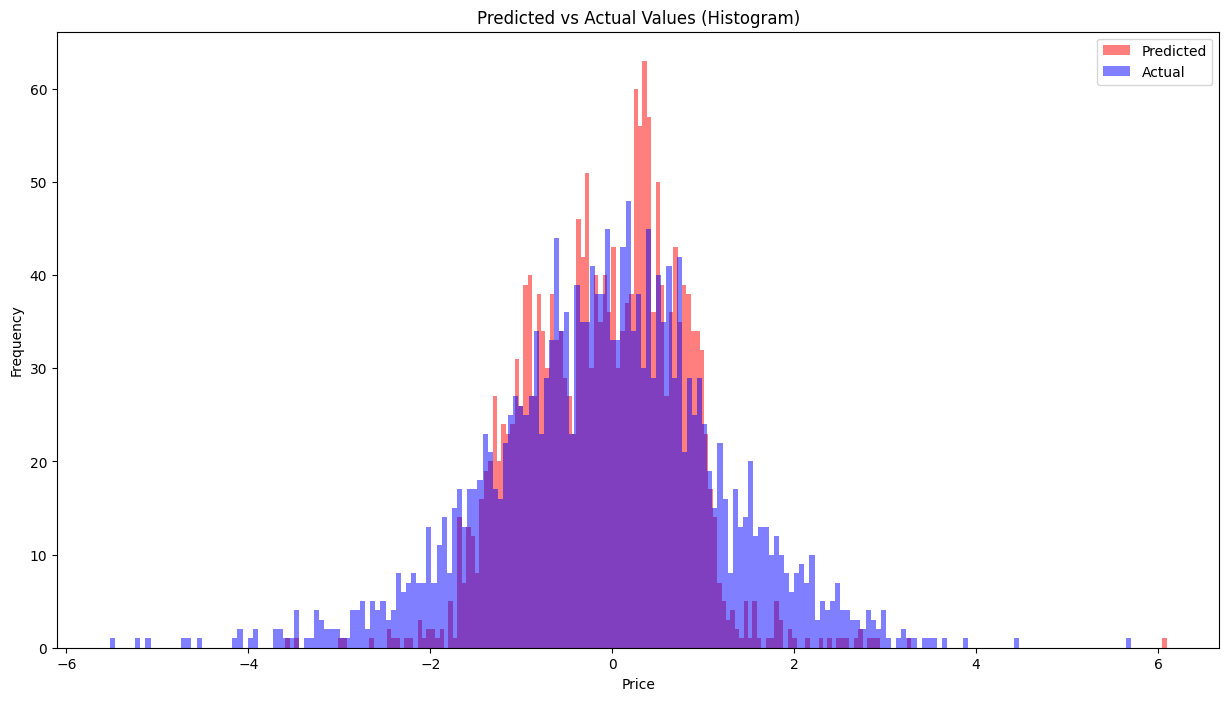

In [ ]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


# Make predictions on the test set
y_pred = model.predict(X_test).flatten()

# Rescale the predictions and actual test values
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Check the lengths to ensure they match
print(f"Length of y_pred_rescaled: {len(y_pred_rescaled)}")
print(f"Length of y_test_rescaled: {len(y_test_rescaled)}")

# Plot histograms of predicted vs actual values
plt.figure(figsize=(15, 8))
plt.hist(y_pred_rescaled, bins=200, alpha=0.5, label='Predicted', color='red')
plt.hist(y_test_rescaled, bins=200, alpha=0.5, label='Actual', color='blue')
plt.legend()
plt.title('Predicted vs Actual Values (Histogram)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

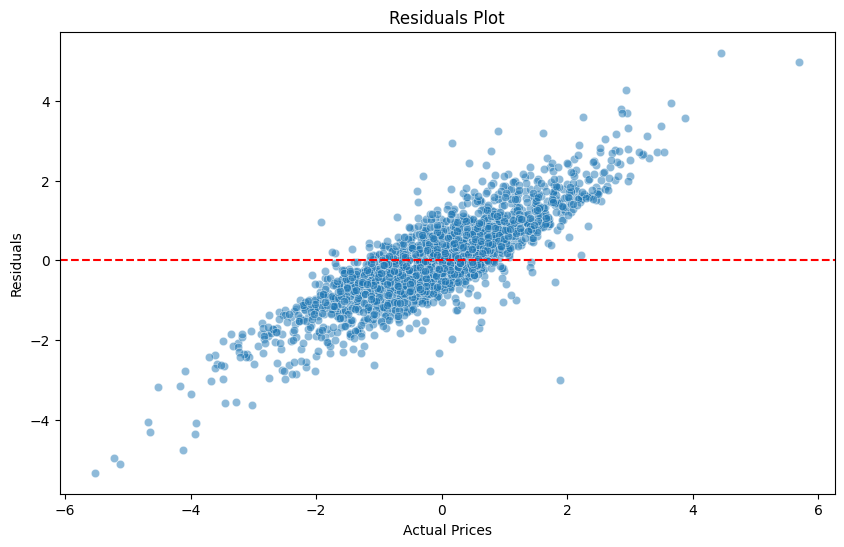

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()


In [ ]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# mae_scores = []
# rmse_scores = []

# for train_index, val_index in kf.split(X_transformed):
#     X_train, X_val = X_transformed[train_index], X_transformed[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     model = build_dense_model((X_train.shape[1],))
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
#     model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

#     y_pred = model.predict(X_val).flatten()
#     mae = mean_absolute_error(y_val, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     mae_scores.append(mae)
#     rmse_scores.append(rmse)

# print(f"Cross-Validation MAE: {np.mean(mae_scores)} (+/- {np.std(mae_scores)})")
# print(f"Cross-Validation RMSE: {np.mean(rmse_scores)} (+/- {np.std(rmse_scores)})")

125/125 [==============================] - 1s 4ms/step
Cross-Validation MAE: 0.8593877651799555 (+/- 0.0038928446085258407)
Cross-Validation RMSE: 1.1295697864870287 (+/- 0.006418451106440381)


In [ ]:
y_pred_test = model.predict(X_test).flatten()
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Test Set MAE: {mae_test}")
print(f"Test Set RMSE: {rmse_test}")

63/63 [==============================] - 0s 2ms/step
Test Set MAE: 0.14889250363240872
Test Set RMSE: 0.2130714416614219


In [ ]:
import pickle

# Save the preprocessor and model to a pickle file
model_file_path = '../models/best_model.pkl'
with open(model_file_path, 'wb') as file:
    pickle.dump((preprocessor, model), file)

# Load the preprocessor and model from the pickle file to test
with open(model_file_path, 'rb') as file:
    loaded_preprocessor, loaded_model = pickle.load(file)

# Test if the loaded model works correctly
# Transform the data using the loaded preprocessor
X_test_transformed = loaded_preprocessor.transform(X_test)

# Make predictions using the loaded model
y_pred_loaded = loaded_model.predict(X_test_transformed).flatten()

# Evaluate the loaded model
mae_loaded = mean_absolute_error(y_test, y_pred_loaded)
rmse_loaded = np.sqrt(mean_squared_error(y_test, y_pred_loaded))

print(f"Loaded Model Mean Absolute Error (MAE): {mae_loaded}")
print(f"Loaded Model Root Mean Squared Error (RMSE): {rmse_loaded}")


NameError: name 'preprocessor' is not defined

In [ ]:
#2

In [ ]:
# split_ratio = 0.02  # 2% for validation, 2% for test
# test_length = int(len(df_sampled) * split_ratio)
# val_length = int((len(df_sampled) - test_length) * split_ratio)
# train_length = len(df_sampled) - val_length - test_length

# # Ensure reproducibility
# df_train = df_sampled.iloc[:train_length, :].sample(frac=1, random_state=42)
# df_val = df_sampled.iloc[train_length:train_length + val_length, :].sample(frac=1, random_state=42)
# df_test = df_sampled.iloc[train_length + val_length:, :].sample(frac=1, random_state=42)

# # Define target and features for each set
# y_train = df_train["price"]
# X_train = df_train.drop(columns=["price"])

# y_val = df_val["price"]
# X_val = df_val.drop(columns=["price"])

# y_test = df_test["price"]
# X_test = df_test.drop(columns=["price"])

# print(f"Training set shape: {X_train.shape}")
# print(f"Validation set shape: {X_val.shape}")
# print(f"Test set shape: {X_test.shape}")

# scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
# y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
# # numeric_columns = X_train.select_dtypes(include=[np.number]).columns
# # categorical_columns = X_train.select_dtypes(exclude=[np.number]).columns
# numeric_columns =['year', 'month','day']
# categorical_columns=['postcode', 'property_type', 'ground', 'property_age']

# numeric_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', RobustScaler())
# ])

# categorical_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_pipeline, numeric_columns),
#         ('cat', categorical_pipeline, categorical_columns)
#     ])

# preprocessor.fit(X_train)
# X_train_transformed = preprocessor.transform(X_train).toarray()
# X_val_transformed = preprocessor.transform(X_val).toarray()
# X_test_transformed = preprocessor.transform(X_test).toarray()

In [ ]:
# sequence_length = 10

# # train_generator = TimeseriesGenerator(X_train_transformed, y_train_scaled, length=sequence_length, batch_size=32)
# # val_generator = TimeseriesGenerator(X_val_transformed, y_val_scaled, length=sequence_length, batch_size=32)
# # test_generator = TimeseriesGenerator(X_test_transformed, y_test_scaled, length=sequence_length, batch_size=32)
# def create_sequences(data, seq_length):
#     sequences = []
#     for i in range(len(data) - seq_length + 1):
#         seq = data[i:i + seq_length]
#         sequences.append(seq)
#     return np.array(sequences)

# # Transform the training data
# X_train_seq = create_sequences(X_train_transformed, sequence_length)
# y_train_seq = create_sequences(y_train_scaled, sequence_length)

# # Transform the validation data
# X_val_seq = create_sequences(X_val_transformed, sequence_length)
# y_val_seq = create_sequences(y_val_scaled, sequence_length)

# # Transform the test data
# X_test_seq = create_sequences(X_test_transformed, sequence_length)
# y_test_seq = create_sequences(y_test_scaled, sequence_length)

In [ ]:
# df['price'].plot(grid=True, marker=".", figsize=(10, 5))
# plt.title("Price Over Indices")
# plt.xlabel("Index")
# plt.ylabel("Price")
# plt.show()

In [ ]:
# def initialize_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(LSTM(50, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(Dense(1))
#     return model

# def compile_model(model):
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#     return model

# input_shape = (sequence_length, X_train_transformed.shape[1])
# model = initialize_model(input_shape)
# model = compile_model(model)

# es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=100,
#     batch_size=32,
#     callbacks=[es],
#     verbose=1
# )

In [ ]:
# y_pred = model.predict(X_test_transformed)
# y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# # Evaluate
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# mse = mean_squared_error(y_test, y_pred_rescaled)
# mae = mean_absolute_error(y_test, y_pred_rescaled)

# print(f"Mean Squared Error: {mse}")
# print(f"Mean Absolute Error: {mae}")

In [ ]:
# test_loss, test_mae = model.evaluate(test_generator)
# print(f'Test MAE: {test_mae}')

In [ ]:
# # #prediction
# y_pred = model.predict(test_generator).flatten()

# # # # Align the test set values
# # # y_test_rescaled_aligned = y_test_scaled[sequence_length:].flatten()

# # # # Rescale the predictions and actual values
# y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
# # # y_test_rescaled_aligned = scaler_y.inverse_transform(y_test_rescaled_aligned.reshape(-1, 1)).flatten()

# # # Check the lengths to ensure they match
# # print(f"Length of y_pred_rescaled: {len(y_pred_rescaled)}")
# # print(f"Length of y_test_rescaled_aligned: {len(y_test_rescaled_aligned)}")

# # plt.figure(figsize=(10, 6))
# # plt.hist(y_pred, bins=50, alpha=0.5, label='Predicted', color='red')
# # plt.hist(y_test, bins=50, alpha=0.5, label='Actual', color='blue')
# # plt.legend()
# # plt.title('Predicted vs Actual Values (Histogram)')
# # plt.xlabel('Price')
# # plt.ylabel('Frequency')
# # plt.show()


# plt.figure(figsize=(15,8))

# plt.hist(y_pred, label='pred', color='r', bins=200, alpha=0.3)
# plt.hist(y_test_scaled, label='truth', color='b', bins=200, alpha=0.3)

# plt.legend()



In [ ]:
# model.summary()

In [ ]:
# from sklearn.model_selection import train_test_split, cross_val_score, KFold

# def cross_validate_rnn_model(X, y, sequence_length, n_splits=5):
#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     val_scores = []

#     for train_index, val_index in kfold.split(X):
#         X_train_fold, X_val_fold = X[train_index], X[val_index]
#         y_train_fold, y_val_fold = y[train_index], y[val_index]

#         train_generator = TimeseriesGenerator(X_train_fold, y_train_fold, length=sequence_length, batch_size=32)
#         val_generator = TimeseriesGenerator(X_val_fold, y_val_fold, length=sequence_length, batch_size=32)

#         model = initialize_model(input_shape)
#         model = compile_model(model)

#         es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

#         history = model.fit(
#             train_generator,
#             validation_data=val_generator,
#             epochs=100,
#             batch_size=32,
#             callbacks=[es],
#             verbose=1
#         )

#         val_loss, val_mae = model.evaluate(val_generator)
#         val_scores.append(val_mae)

#     return val_scores

# #  cross-validation on the RNN model
# val_scores = cross_validate_rnn_model(X_train_transformed, y_train_scaled, sequence_length)
# print(f'Cross-Validation MAE Scores: {val_scores}')
# print(f'Mean Cross-Validation MAE: {np.mean(val_scores)}')


In [ ]:
#second attempt:

In [ ]:
# df_sampled['log_return'] = np.log(df_sampled['price'] / df_sampled['price'].shift(1))
# df_sampled = df_sampled.dropna(subset=['log_return'])

# # Define the target and features
# y = df_sampled['log_return']
# X = df_sampled.drop(columns=['log_return', 'price'])

# # Define numerical and categorical columns
# numeric_columns = ['year', 'month', 'day']
# categorical_columns = ['postcode', 'property_type', 'property_age', 'ground']

# # Preprocessing pipelines for numerical and categorical data
# numeric_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# categorical_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Column transformer to preprocess both numerical and categorical data
# preprocessor = ColumnTransformer([
#     ('num', numeric_pipeline, numeric_columns),
#     ('cat', categorical_pipeline, categorical_columns)
# ])

# # Transform the data
# X_transformed = preprocessor.fit_transform(X)

# # Split the data into train, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Print the shapes to ensure correct splitting
# print(f"X_train shape: {X_train.shape}")
# print(f"X_val shape: {X_val.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_val shape: {y_val.shape}")
# print(f"y_test shape: {y_test.shape}")

In [ ]:

# def create_sequences(X, y, sequence_length):
#     sequences_X = []
#     sequences_y = []
    
#     for i in range(len(X) - sequence_length):
#         print(f"Processing index: {i}")  # Debug statement
#         if i + sequence_length >= len(X):
#             print(f"Skipping index: {i} as it exceeds bounds")
#             continue
#         try:
#             seq_X = X[i:i+sequence_length]
#             seq_y = y[i+sequence_length]
#             print(f"seq_X shape: {seq_X.shape}, seq_y: {seq_y}")  # Debug statement
#             sequences_X.append(seq_X)
#             sequences_y.append(seq_y)
#         except KeyError as err:
#             print(f"KeyError at index {i}: {err}")
#         except IndexError as err:
#             print(f"IndexError at index {i}: {err}")
        
#     return np.array(sequences_X), np.array(sequences_y)

# sequence_length = 10
# X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
# X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)
# X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# # Print the shapes to ensure correct sequence creation
# print("X_train_seq shape:", X_train_seq.shape)
# print("y_train_seq shape:", y_train_seq.shape)
# print("X_val_seq shape:", X_val_seq.shape)
# print("y_val_seq shape:", y_val_seq.shape)
# print("X_test_seq shape:", X_test_seq.shape)
# print("y_test_seq shape:", y_test_seq.shape)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# def initialize_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(LSTM(50, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(Dense(1))
#     return model

# def compile_model(model):
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#     return model

# input_shape = (sequence_length, X_train_seq.shape[2])
# model = initialize_model(input_shape)
# model = compile_model(model)

# es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# history = model.fit(
#     X_train_seq, y_train_seq,
#     validation_data=(X_val_seq, y_val_seq),
#     epochs=100,
#     batch_size=32,
#     callbacks=[es],
#     verbose=1
# )


In [ ]:
# # Predict log returns for the test set
# y_pred_log_returns = model.predict(X_test_seq).flatten()

# # Convert predicted log returns to actual prices
# initial_prices = df['price'].values[-len(y_test_seq):]  # Adjust based on your actual data
# y_pred_prices = initial_prices * np.exp(y_pred_log_returns)
# y_test_prices = df['price'].values[-len(y_pred_prices):]  # Adjust based on your actual data

# # Evaluate the predictions
# mae = mean_absolute_error(y_test_prices, y_pred_prices)
# rmse = np.sqrt(mean_squared_error(y_test_prices, y_pred_prices))

# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"Root Mean Squared Error (RMSE): {rmse}")

# # Plot the predictions
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test_prices, y=y_pred_prices, alpha=0.5)
# plt.xlabel('Actual Prices')
# plt.ylabel('Predicted Prices')
# plt.title('Actual vs Predicted Prices')
# plt.plot([y_test_prices.min(), y_test_prices.max()], [y_test_prices.min(), y_test_prices.max()], 'k--', lw=2)
# plt.show()


In [ ]:
# postcode_example = 'E6 2EN'
# sample_data = {
#     'price': [0],  # Placeholder for price, as it will be predicted
#     'year': [2022],  # Example year
#     'month': [6],  # Example month
#     'day': [21],  # Example day
#     'postcode': [postcode_example],
#     'property_type': ['F'],  # Example property type
#     'property_age': ['N'],  # Example property age
#     'ground': ['F'],  # Example ground type
#     'log_return': [0]  # Placeholder for log_return, as it will be predicted
# }

# sample_df = pd.DataFrame(sample_data)
# sample_transformed = preprocessor.transform(sample_df)

# # Ensure the transformed data matches the sequence length expected by the model
# sample_transformed = np.tile(sample_transformed, (sequence_length, 1)).reshape(1, sequence_length, -1)

# # Make a prediction
# prediction_scaled = model.predict(sample_transformed).flatten()
# predicted_price = scaler_y.inverse_transform(prediction_scaled.reshape(-1, 1)).flatten()[0]

# print(f"Predicted price for postcode {postcode_example}: {predicted_price}")


In [ ]:
# # Define the sample data for the given postcode
# postcode_example = 'E6 2EN'
# sample_data = {
#     'price': [0],  # Placeholder for price, as it will be predicted
#     'year': [2022],  # Example year
#     'month': [6],  # Example month
#     'day': [21],  # Example day
#     'postcode': [postcode_example],
#     'property_type': ['F'],  # Example property type
#     'property_age': ['N'],  # Example property age
#     'ground': ['F'],  # Example ground type
#     'log_return': [0]  # Placeholder for log_return, as it will be predicted
# }

# # Get the last known price for the postcode
# last_known_price = df[df['postcode'] == postcode_example]['price'].iloc[-1]

# # Create a DataFrame from the sample data
# sample_df = pd.DataFrame(sample_data)
# sample_transformed = preprocessor.transform(sample_df)

# # Ensure the transformed data matches the sequence length expected by the model
# sample_transformed = np.tile(sample_transformed, (sequence_length, 1)).reshape(1, sequence_length, -1)

# # Make a prediction
# prediction_log_return = model.predict(sample_transformed).flatten()[0]

# # Convert the predicted log return to an absolute price
# predicted_price = last_known_price * np.exp(prediction_log_return)

# print(f"Predicted absolute price for postcode {postcode_example}: {predicted_price}")


In [ ]:
# from scipy.sparse import issparse
# import keras_tuner as kt
# # Function to convert to dense if sparse
# def to_dense(array):
#     return array.toarray() if issparse(array) else array

# # Ensure X_train, X_val, and X_test are dense arrays
# X_train_dense = to_dense(X_train)
# X_val_dense = to_dense(X_val)
# X_test_dense = to_dense(X_test)

# # Proceed with the same code as before
# y_train_array = np.array(y_train)
# y_val_array = np.array(y_val)
# y_test_array = np.array(y_test)

# sequence_length = 10

# train_generator = TimeseriesGenerator(X_train_dense, y_train_array, length=sequence_length, batch_size=32)
# val_generator = TimeseriesGenerator(X_val_dense, y_val_array, length=sequence_length, batch_size=32)
# test_generator = TimeseriesGenerator(X_test_dense, y_test_array, length=sequence_length, batch_size=32)

# print(f"Number of samples in train_generator: {len(train_generator)}")
# print(f"Number of samples in val_generator: {len(val_generator)}")
# print(f"Number of samples in test_generator: {len(test_generator)}")



# y_train_array = np.array(y_train)
# y_val_array = np.array(y_val)
# y_test_array = np.array(y_test)

# sequence_length = 10

# # Create Timeseries Generators
# train_generator = TimeseriesGenerator(X_train_dense, y_train_array, length=sequence_length, batch_size=32)
# val_generator = TimeseriesGenerator(X_val_dense, y_val_array, length=sequence_length, batch_size=32)
# test_generator = TimeseriesGenerator(X_test_dense, y_test_array, length=sequence_length, batch_size=32)

# # Define the model building function
# def build_model(hp):
#     model = Sequential()
#     model.add(layers.LSTM(units=hp.Int('units1',
#                                        min_value=50,
#                                        max_value=200,
#                                        step=50),
#                           activation='tanh',
#                           return_sequences=True,
#                           input_shape=(sequence_length, X_train_dense.shape[1]),
#                           kernel_regularizer=keras.regularizers.l2(0.01)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(hp.Float('dropout_rate1',
#                                       min_value=0.2,
#                                       max_value=0.5,
#                                       step=0.1)))

#     model.add(layers.LSTM(units=hp.Int('units2',
#                                        min_value=50,
#                                        max_value=200,
#                                        step=50),
#                           activation='relu',
#                           return_sequences=True,
#                           kernel_regularizer=keras.regularizers.l2(0.01)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(hp.Float('dropout_rate2',
#                                       min_value=0.2,
#                                       max_value=0.5,
#                                       step=0.1)))

#     model.add(layers.LSTM(units=hp.Int('units3',
#                                        min_value=50,
#                                        max_value=200,
#                                        step=50),
#                           activation='relu',
#                           kernel_regularizer=keras.regularizers.l2(0.01)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(hp.Float('dropout_rate3',
#                                       min_value=0.2,
#                                       max_value=0.5,
#                                       step=0.1)))

#     model.add(layers.Dense(1))

#     model.compile(
#         optimizer=Adam(
#             hp.Choice('learning_rate',
#                       values=[1e-2, 1e-3, 1e-4])),
#         loss='mean_squared_error',
#         metrics=['mae'])

#     return model

# # Initialize the RandomSearch tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_mae',
#     max_trials=5,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='london_real_estate_price_prediction')

# # Start the search
# tuner.search(train_generator, epochs=50, validation_data=val_generator)

# # Get the best models
# best_models = tuner.get_best_models(num_models=1)
# best_model = best_models[0]

# # Evaluate the best model
# y_pred = best_model.predict(test_generator).flatten()

# # Convert log returns to actual prices
# initial_prices = df['price'].values[:len(y_test_seq)]
# y_pred_prices = initial_prices * np.exp(y_pred)
# y_test_prices = initial_prices * np.exp(y_test_array[:len(y_test_seq)])

# # Calculate MAE and RMSE
# mae = mean_absolute_error(y_test_prices, y_pred_prices)
# rmse = np.sqrt(mean_squared_error(y_test_prices, y_pred_prices))

# print(f"Test Set MAE: {mae}")
# print(f"Test Set RMSE: {rmse}")

# # Plot actual vs predicted prices
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test_prices, y_pred_prices, alpha=0.5)
# plt.xlabel('Actual Prices')
# plt.ylabel('Predicted Prices')
# plt.title('Actual vs Predicted Prices')
# plt.plot([y_test_prices.min(), y_test_prices.max()], [y_test_prices.min(), y_test_prices.max()], 'k--', lw=2)
# plt.show()

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
import pickle

# Load and preprocess the data
file_path = '../raw_data/london_real_estate_data.zip'
df = pd.read_csv(file_path, compression='zip')
df.fillna({'additional_info':''}, inplace=True)
df['full_property_number'] = df['number'] + '' + df['additional_info']
df.drop(columns=['number', 'additional_info', 'locality', 'town', 'county'], inplace=True)
df.rename(columns={'district': 'borough'}, inplace=True)
df_sampled = df.sample(n=20000, random_state=1)
df_sampled['log_return'] = np.log(df_sampled['price'] / df_sampled['price'].shift(1))
df_sampled = df_sampled.dropna(subset=['log_return'])

y = df_sampled['log_return']
X = df_sampled.drop(columns=['log_return', 'price'])
X.columns = X.columns.str.strip()
X = X.loc[:, ~pd.isna(X.columns)]

numeric_columns = ['year', 'month', 'day']
categorical_columns = ['postcode', 'property_type', 'property_age', 'ground']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

X_transformed = preprocessor.fit_transform(X)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# Scale the target variable
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def build_dense_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer
    return model

input_shape = (X_train.shape[1],)
model = build_dense_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

with open('../models/best_model.pkl', 'wb') as file:
    pickle.dump({'model': model, 'preprocessor': preprocessor, 'scaler_y': scaler_y}, file)

Epoch 1/50


In [ ]:
# import pandas as pd
# import numpy as np
# import pickle

# # Load the pickle file
# with open('../models/best_model.pkl', 'rb') as file:
#     saved_objects = pickle.load(file)

# model = saved_objects['model']
# preprocessor = saved_objects['preprocessor']
# scaler_y = saved_objects['scaler_y']

# # Define new data to test
# postcode_example = 'N1 2JU'
# sample_data = {
#     'year': [2022],
#     'month': [6],
#     'day': [21],
#     'postcode': [postcode_example],
#     'property_type': ['F'],
#     'property_age': ['N'],
#     'ground': ['F']
# }

# sample_df = pd.DataFrame(sample_data)

# # Transform the sample data using the preprocessor
# sample_transformed = preprocessor.transform(sample_df)

# # Make a prediction
# prediction_log_return = model.predict(sample_transformed).flatten()[0]

# # Convert log return to actual price
# initial_price = df[df['postcode'] == postcode_example]['price'].iloc[-1]
# predicted_price = initial_price * np.exp(prediction_log_return)

# print(f"Predicted price for postcode {postcode_example}: {predicted_price}")


1/1 [==============================] - 0s 77ms/step
Predicted price for postcode N1 2JU: 1859815.334558487


In [ ]:
# postcode_example = 'N1 2JU'
# sample_data = {
#     'year': [2022],
#     'month': [6],
#     'day': [21],
#     'postcode': [postcode_example],
#     'property_type': ['F'],
#     'property_age': ['N'],
#     'ground': ['F']
# }

# sample_df = pd.DataFrame(sample_data)

# # Transform the sample data using the preprocessor
# sample_transformed = preprocessor.transform(sample_df)

# # Make a prediction
# prediction_log_return = model.predict(sample_transformed).flatten()[0]

# # Convert log return to actual price
# initial_price = df[df['postcode'] == postcode_example]['price'].iloc[-1]
# predicted_price = initial_price * np.exp(prediction_log_return)

# print(f"Predicted price for postcode {postcode_example}: {predicted_price}")

In [2]:
import pickle
with open('../models/best_model.pkl', 'rb') as file:
    saved_objects = pickle.load(file)

model = saved_objects['model']
preprocessor = saved_objects['preprocessor']
scaler_y = saved_objects['scaler_y']

# Define new data to test
new_data = {
    'year': [2022],
    'month': [11],
    'day': [25],
    'postcode': ['N1 2JU'],
    'property_type': ['F'],
    'property_age': ['N'],
    'ground': ['F']
}

new_df = pd.DataFrame(new_data)

# Preprocess the new data
new_X_transformed = preprocessor.transform(new_df)
if hasattr(new_X_transformed, "toarray"):
    new_X_transformed = new_X_transformed.toarray()

# Make predictions on the new data
new_y_pred_log_return = model.predict(new_X_transformed).flatten()

# If the target was log-transformed, convert it back to the original scale
initial_price = df[df['postcode'] == 'N1 2JU']['price'].iloc[-1]  # Example to get the initial price
new_y_pred = initial_price * np.exp(new_y_pred_log_return[0])

print(f"Predicted price for new data: {new_y_pred}")

EOFError: Ran out of input